In [159]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [160]:
fs = 20 # fontsize
lw = 2  # line width
width = 15 # figure width
height = 8 # figure height
plt.rcParams["axes.formatter.useoffset"] = False # No tick label offset
plt.rcParams.update({'font.size': fs-4}) # Standard font size 

In [161]:
path = "Data\co2_mm_mlo.csv"
t, co2, co2_av = np.loadtxt(path, skiprows = 53,delimiter = ',',comments='#',usecols=(2,3,4),unpack=True)

Given: Time series of measurements of concentration $\vec{c}=(c_1,c_2,...,c_m)$ According to time $\vec{t}=(t_1,t_2,...,t_)$.

Forward model: Polynome of order 4
\begin{equation}
c(t)=a_0+a_1 \cdot t+a_2 \cdot t^2+a_3 \cdot t^3+a_4 \cdot t^4 = \sum_{i=0}^4a_i \cdot t^i
\end{equation}
Matrix notation:
\begin{equation}
\vec{c(t)}= K \vec{a}
\end{equation}

with $\vec{a}= \left(\begin{array}{c} a_0 \\ a_1 \\ a_2 \\ a_3 \\ a_4 \end{array}\right)$ and  $K = 
  \begin{pmatrix}
    t_1^0 & t_1 & t_1^2 & t_1^3 & t_1^4 \\
    t_2^0 & t_2 & t_2^2 & t_2^3 & t_2^4 \\
    t_3^0 & t_3 & t_3^2 & t_3^3 & t_3^4 \\
    ... && ... && ...  \\
  \end{pmatrix}$


In [162]:
def forward_model(timeseries, n):
    
    K_T= np.zeros([n,len(timeseries)])
    for j in range(n):
        K_T[j]= timeseries**j
        
    K_model=np.transpose(K_T)
    
    return K_model

In [163]:
orderp1 = 5 
K = forward_model(t, orderp1)
a_fit, r, rank, sv = np.linalg.lstsq(K,co2, rcond=1)
c_fit= np.matmul(K,a_fit)

print("K is an (mxn) matrix with m= "+ str(len(t))+ " and n=" + str(orderp1)+ ". The rank of K is " + str(rank) + "." )

K is an (mxn) matrix with m= 776 and n=5. The rank of K is 3.


As K is no square matrix, there is no inverse of K, thus there is no exact solution of the problem.

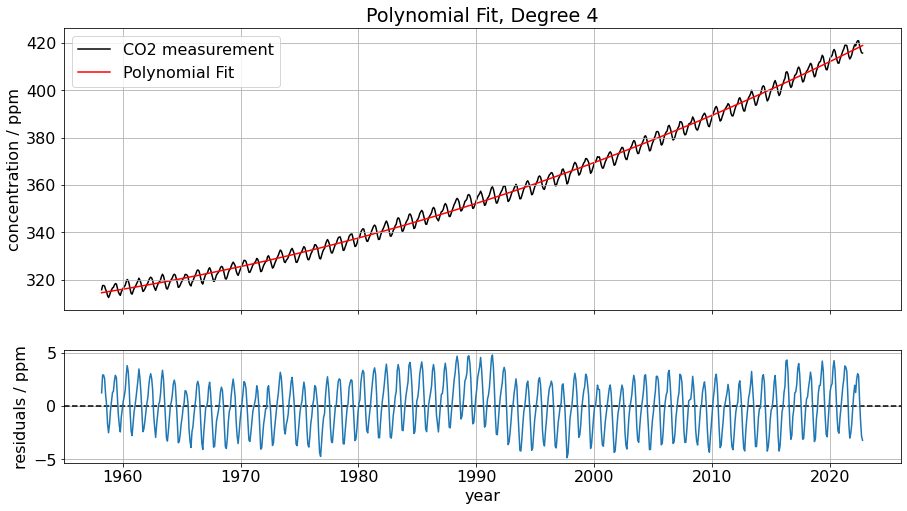

In [164]:
fig, (ax, res) = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [5, 2]}, figsize=(width, height))
ax.plot(t,co2,label="CO2 measurement",color="black",zorder=1)
ax.plot(t,c_fit,label="Polynomial Fit",color="red",zorder=1)

res.errorbar( t, co2 - c_fit, capsize=3)

res.axhline(0, linestyle="--", color="black")
res.grid()
ax.grid()
res.set_xlabel("year")
res.set_ylabel('residuals / ppm')
ax.set_ylabel("concentration / ppm")
ax.set_title("Polynomial Fit, Degree 4")
ax.legend()

Residuals show systematic deviation from fit curve (Oscillation around zero).
--> polynomial fit does not describe underlying measurement very well --> Oscillating term should be introduced.

Advanced forward model: polynome of order 4, overlaid with fourier series of order 4
\begin{equation}
c(t) = \sum_{i=0}^4 a_i \cdot t^i + b_i\cos(2\pi \cdot i \cdot t) +c_i\sin(2\pi \cdot i\cdot t)
\end{equation}

Matrix notation:
\begin{equation}
\vec{c(t)}= K \vec{a}
\end{equation}

with $\vec{a}= \left(\begin{array}{c} a_0 \\ ... \\ a_4 \\ b_0 \\ ... \\ b_4 \\ c_0 \\ ... \\ c_4  \end{array}\right)$ and  $K = 
  \begin{pmatrix}
    t_1^0 & ... & t_1^4 & \cos(2\pi \cdot 0 \cdot t_1) & ... & \cos(2\pi \cdot 0 \cdot t_1) & \sin(2\pi \cdot 0 \cdot t_1) & ... & \sin(2\pi \cdot 4 \cdot t_1) \\
    t_2^0 & ... & t_2^4 & \cos(2\pi \cdot 0 \cdot t_2) & ... & \cos(2\pi \cdot 4 \cdot t_2) & \sin(2\pi \cdot 0 \cdot t_2) & ... & \sin(2\pi \cdot 4 \cdot t_2) \\
    t_3^0 & ... & t_3^4 & \cos(2\pi \cdot 0 \cdot t_3) & ... & \cos(2\pi \cdot 4 \cdot t_3) & \sin(2\pi \cdot 0 \cdot t_3) & ... & \sin(2\pi \cdot 4 \cdot t_3) \\
    &...& & &...& & &...& \\
  \end{pmatrix}$
  

In [165]:
def advanced_forward_model(timeseries, order_poly, order_fourier):
    
    K_T= np.zeros([2*order_fourier+order_poly,len(timeseries)])
    
    for j in range(order_poly):
        K_T[j]= timeseries**j
    for j in range(order_fourier):  
        K_T[j+order_poly]= np.cos(2*np.pi*j*timeseries)
        K_T[j+order_poly+order_fourier]= np.sin(2*np.pi*j*timeseries)
        
    K=np.transpose(K_T)
    
    return K

In [166]:
n_poly = 5
n_fourier= 5
K_2 = advanced_forward_model(t, n_poly, n_fourier)

x_fit_2, r_2, rank_2, sv_2 = np.linalg.lstsq(K_2,co2, rcond=1)
y_fit_2= np.matmul(K_2,x_fit_2)

print("K is an (mxn) matrix with m= "+ str(len(t))+ " and n=" + str(5)+ ". The rank of K is " + str(rank) + "." )

K is an (mxn) matrix with m= 776 and n=5. The rank of K is 3.


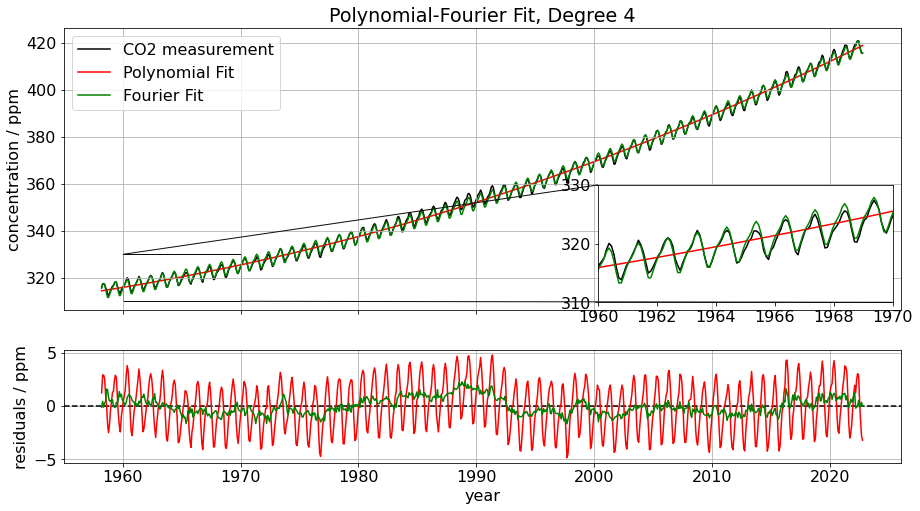

In [168]:
fig, (ax, res) = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [5, 2]}, figsize=(width, height))

axins = zoomed_inset_axes(ax, 2.5, loc=4)
axins.plot(t,co2,color="black" )
axins.plot(t,y_fit,color="red" )
axins.plot(t,y_fit_2,color="green" )
x1, x2, y1, y2 = 1960, 1970, 310, 330 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.05")

ax.plot(t,co2,label="CO2 measurement",color="black",zorder=1)
ax.plot(t,y_fit,label="Polynomial Fit",color="red",zorder=1)
ax.plot(t,y_fit_2,label="Fourier Fit",color="green",zorder=1)

res.errorbar( t, co2 - y_fit,label="Polynomial Residuals",color="red", capsize=3)
res.errorbar( t, co2 - y_fit_2,label="Fourier Residuals",color="green", capsize=3)

res.axhline(0, linestyle="--", color="black")
res.grid()
ax.grid()
res.set_xlabel("year")
res.set_ylabel('residuals / ppm')
ax.set_ylabel("concentration / ppm")
ax.set_title("Polynomial-Fourier Fit, Degree 4")
ax.legend(loc=2)